In [30]:
%load_ext autoreload
%autoreload 2

import os
import sys
import json
from pathlib import Path

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../src')
from settings import REPLAY_DIR, YOUTUBE_DIR, TIMESTAMPS_DIR
from youtube import convert_to_timestamp
from dota import Match
from highlights import find_hp_decreasing_intervals, find_low_hp_intervals, find_low_and_decreasing_hp_intervals

pd.options.display.max_columns = 60

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
match = Match(6676393091, Path(REPLAY_DIR) / '6676393091.jsonlines')
match._parse_events()
match

Match: 6676393091, parsed: True

In [3]:
player = match.players[1]
player

MatchPlayer at match: 6676393091, slot: 1, hero_name: npc_dota_hero_pangolier, steam_id: 76561198134243802

In [4]:
player.hp

-89       580
-88       580
-87       580
-86       580
-85       580
         ... 
 2076    2413
 2077    2430
 2078    2515
 2079    2512
 2080    2490
Name: hp, Length: 2170, dtype: int64

In [5]:
player.hp.t(15 * 60, 16 * 60)

900    1250
901    1250
902    1238
903    1239
904    1278
       ... 
956    1290
957    1290
958    1290
959    1258
960    1138
Name: hp, Length: 61, dtype: int64

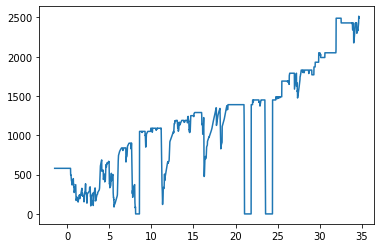

In [6]:
plt.plot(player.hp.index / 60, player.hp)

## Deaths

In [7]:
player.deaths

,time,type,value,attackername,targetname,sourcename,targetsourcename,attackerhero,targethero,attackerillusion,targetillusion,inflictor
0,487,DOTA_COMBATLOG_DEATH,131,npc_dota_hero_ember_spirit,npc_dota_hero_pangolier,npc_dota_hero_ember_spirit,npc_dota_hero_pangolier,True,True,False,False,dota_unknown
1,1263,DOTA_COMBATLOG_DEATH,22,npc_dota_hero_skywrath_mage,npc_dota_hero_pangolier,npc_dota_hero_skywrath_mage,npc_dota_hero_pangolier,True,True,False,False,skywrath_mage_mystic_flare
2,1412,DOTA_COMBATLOG_DEATH,237,npc_dota_hero_luna,npc_dota_hero_pangolier,npc_dota_hero_luna,npc_dota_hero_pangolier,True,True,False,False,luna_lucent_beam


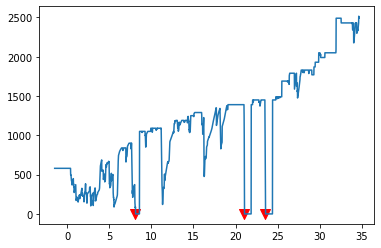

In [8]:
fig, ax = plt.subplots()
ax.plot(player.hp.index / 60, player.hp)
ax.scatter(x=player.deaths['time'] / 60, y=np.full(player.deaths.shape[0], 0), color='r', marker='v', s=100)
plt.show()

## YouTube

In [9]:
df_youtube = pd.read_csv(YOUTUBE_DIR / 'XTngObUROMo.csv')
df_youtube

,video_id,cluster,start,end,start_time,end_time
0,XTngObUROMo,0,00:19,00:02,19,2
1,XTngObUROMo,1,01:00,01:19,60,79
2,XTngObUROMo,2,02:38,03:14,158,194
3,XTngObUROMo,3,04:30,05:35,270,335
4,XTngObUROMo,4,14:19,14:56,859,896
5,XTngObUROMo,5,15:53,16:13,953,973
6,XTngObUROMo,6,18:06,18:13,1086,1093
7,XTngObUROMo,7,18:47,18:56,1127,1136
8,XTngObUROMo,8,21:11,21:47,1271,1307
9,XTngObUROMo,9,22:34,24:25,1354,1465


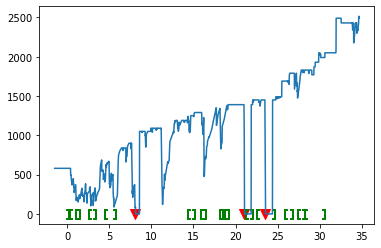

In [10]:
fig, ax = plt.subplots()
ax.plot(player.hp.index / 60, player.hp)
ax.scatter(x=player.deaths['time'] / 60, y=np.full(player.deaths.shape[0], 0), color='r', marker='v', s=100)
ax.scatter(x=df_youtube['start_time'] / 60, y=np.full(df_youtube.shape[0], 0), color='g', marker='$[$', s=100)
ax.scatter(x=df_youtube['end_time'] / 60, y=np.full(df_youtube.shape[0], 0), color='g', marker='$]$', s=100)
plt.show()

## Remove trend

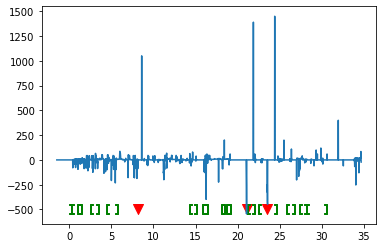

In [11]:
fig, ax = plt.subplots()
# ax.plot(player.hp.index / 60, player.hp)
ax.plot(player.dhp.index / 60, player.dhp)
ax.scatter(x=player.deaths['time'] / 60, y=np.full(player.deaths.shape[0], -500), color='r', marker='v', s=100)
ax.scatter(x=df_youtube['start_time'] / 60, y=np.full(df_youtube.shape[0], -500), color='g', marker='$[$', s=100)
ax.scatter(x=df_youtube['end_time'] / 60, y=np.full(df_youtube.shape[0], -500), color='g', marker='$]$', s=100)
plt.show()

## Zoom

In [12]:
# 11:09 - 11:30

In [13]:
zoom_start = 10.5 * 60
zoom_end = 12 * 60
df_youtube_slice = df_youtube[(df_youtube['start_time'] >= zoom_start) & (df_youtube['end_time'] <= zoom_end)]

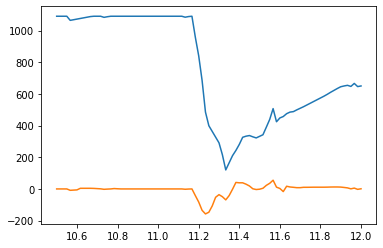

In [14]:
fig, ax = plt.subplots()
ax.plot(player.hp.t(zoom_start, zoom_end).index / 60, player.hp.t(zoom_start, zoom_end))
ax.plot(player.sdhp.t(zoom_start, zoom_end).index / 60, player.sdhp.t(zoom_start, zoom_end))
ax.scatter(
    x=player.deaths.t(zoom_start, zoom_end)['time'] / 60, 
    y=np.full(player.deaths.t(zoom_start, zoom_end).shape[0], -500),
    color='r', marker='v', s=100)
ax.scatter(x=df_youtube_slice['start_time'] / 60, y=np.full(df_youtube_slice.shape[0], -500), color='g', marker='$[$', s=100)
ax.scatter(x=df_youtube_slice['end_time'] / 60, y=np.full(df_youtube_slice.shape[0], -500), color='g', marker='$]$', s=100)
plt.show()

Начало

- Отрицательная скорость (Может медленно убывать)
- Абсолютное значение хп < 30%

Конец
- Конец падения хп

In [15]:
from utils import TimeSeries

In [16]:
player.hp / player.max_hp

-89      1.000000
-88      1.000000
-87      1.000000
-86      1.000000
-85      1.000000
           ...   
 2076    0.993004
 2077    1.000000
 2078    1.000000
 2079    0.998807
 2080    0.990060
Name: hp, Length: 2170, dtype: float64

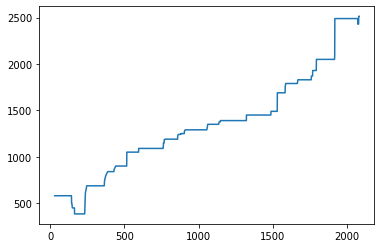

In [17]:
plt.plot(player.hp.rolling(120).max())

In [18]:
signal_sdhp = player.sdhp < -20
signal_sdhp = TimeSeries(signal_sdhp)

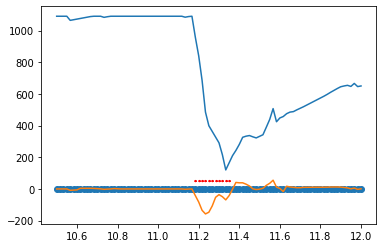

In [19]:
fig, ax = plt.subplots()
ax.plot(player.hp.t(zoom_start, zoom_end).index / 60, player.hp.t(zoom_start, zoom_end))
ax.plot(player.sdhp.t(zoom_start, zoom_end).index / 60, player.sdhp.t(zoom_start, zoom_end))
ax.scatter(
    x=player.deaths.t(zoom_start, zoom_end)['time'] / 60, 
    y=np.full(player.deaths.t(zoom_start, zoom_end).shape[0], -500),
    color='r', marker='v', s=100)
ax.scatter(x=df_youtube_slice['start_time'] / 60, y=np.full(df_youtube_slice.shape[0], -500), color='g', marker='$[$', s=100)
ax.scatter(x=df_youtube_slice['end_time'] / 60, y=np.full(df_youtube_slice.shape[0], -500), color='g', marker='$]$', s=100)
ax.scatter(x=signal_sdhp.t(zoom_start, zoom_end).index / 60, y=signal_sdhp.t(zoom_start, zoom_end) * 50, color='r', marker='$*$', s=5)
ax.scatter(x=signal_sdhp.t(zoom_start, zoom_end).index / 60, y=signal_sdhp.t(zoom_start, zoom_end))
plt.show()

# Detector

In [50]:
df_attacks = find_low_and_decreasing_hp_intervals(player)
df_attacks = pd.DataFrame(df_attacks)
df_attacks

,start,end
0,62,66
1,120,123
2,133,143
3,165,171
4,185,188
5,328,337
6,456,468
7,482,491
8,671,682
9,1261,1267


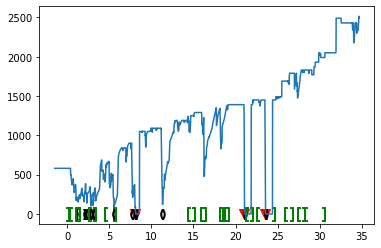

In [53]:
fig, ax = plt.subplots()
ax.plot(player.hp.index / 60, player.hp)
ax.scatter(x=player.deaths['time'] / 60, y=np.full(player.deaths.shape[0], 0), color='r', marker='v', s=100)
ax.scatter(x=df_attacks['start'] / 60, y=np.full(df_attacks.shape[0], 0), color='black', marker='$($', s=100)
ax.scatter(x=df_attacks['end'] / 60, y=np.full(df_attacks.shape[0], 0), color='black', marker='$)$', s=100)
ax.scatter(x=df_youtube['start_time'] / 60, y=np.full(df_youtube.shape[0], 0), color='green', marker='$[$', s=200)
ax.scatter(x=df_youtube['end_time'] / 60, y=np.full(df_youtube.shape[0], 0), color='green', marker='$]$', s=200)
plt.show()